# Required Dependencies


In [1]:
# TensorFlow and Keras imports
import warnings

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.metrics import classification_report, confusion_matrix

# Other imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image  # For displaying images in Jupyter notebooks
import glob




In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/custom-waste-classification-dataset/wastes/test/paper waste/paper waste (241).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/glass waste/glass waste (161).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/organic waste/organic waste (27).png
/kaggle/input/custom-waste-classification-dataset/wastes/test/plastic waste/plastic waste (3).png
/kaggle/input/custom-waste-classification-dataset/wastes/test/automobile wastes/automobile waste  (21).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/metal waste/metal waste (276).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/battery waste/battery waste (160).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/E-waste/e-waste (110).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/test/light bulbs/light bulb waste (104).jpg
/kaggle/input/custom-waste-classification-dataset/wastes/train/paper waste/paper waste (818).jpg
/kaggle/input/custom-w

In [3]:
!cp /kaggle/input/custom-waste-classification-dataset/wastes/ /kaggle/working/wastes/ -r

In [4]:
!ls -l

total 48
---------- 1 root root 45044 Apr 11 11:00 __notebook__.ipynb
drwxr-xr-x 4 root root  4096 Apr 11 11:00 wastes


In [5]:
!ls wastes/

test  train


In [6]:
# Set the base directory for the dataset
BASE_DIR = r"wastes/"  # Change this to the path where your dataset is located

# Define the paths to the training and test directories
train_dir = os.path.join(BASE_DIR, 'train')  # Path to the training data
test_dir = os.path.join(BASE_DIR, 'test')    # Path to the test data


# Data Visualization

Number of training samples in class 'light bulbs': 420


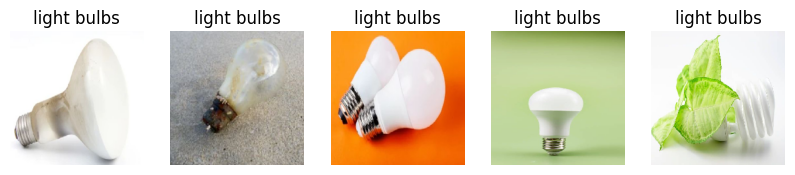

Number of training samples in class 'battery waste': 846


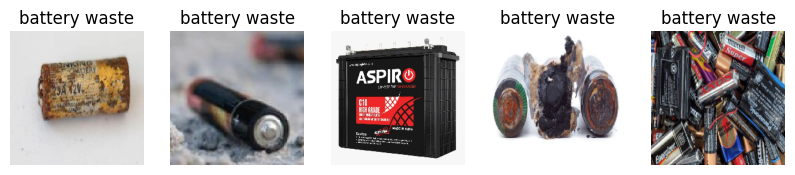

Number of training samples in class 'automobile wastes': 867


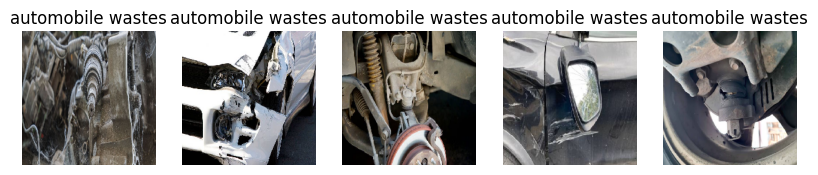

Number of training samples in class 'E-waste': 1248


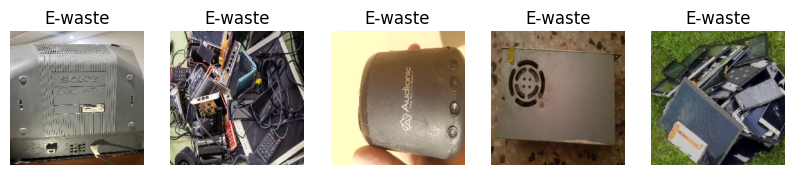

Number of training samples in class 'plastic waste': 1191


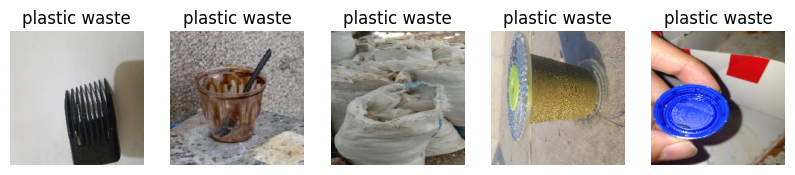

Number of training samples in class 'glass waste': 1018


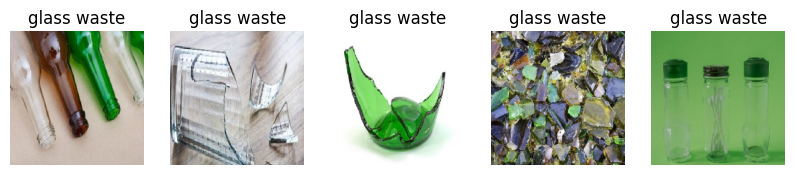

Number of training samples in class 'organic waste': 442


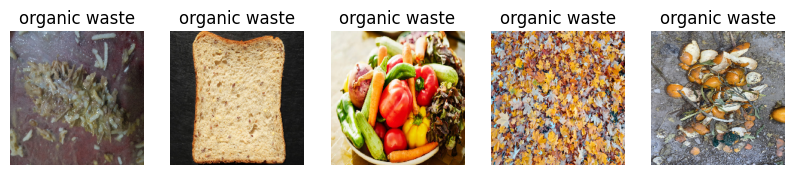

Number of training samples in class 'metal waste': 1214


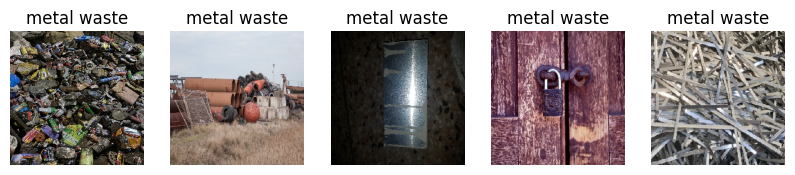

Number of training samples in class 'paper waste': 1333


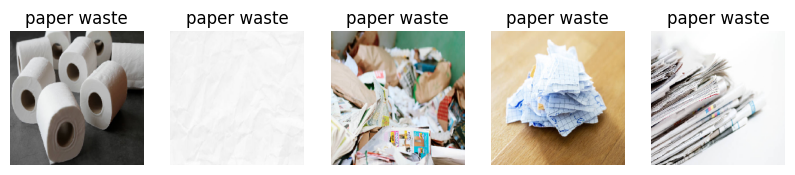

In [7]:
# Define your training directory path
train_dir = r"wastes/train"  # Replace with your actual training folder path

# List all the class names in your training dataset
class_names = os.listdir(train_dir)

# Visualize and count the number of images in each class for training data
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    class_images = glob.glob(os.path.join(class_dir, '*.jpg'))  # Assuming .jpg files
    print(f"Number of training samples in class '{class_name}': {len(class_images)}")

    # Visualizing some random images from each class (to get a sense of the data)
    if len(class_images) > 0:
        plt.figure(figsize=(10, 5))
        for i in range(5):  # Displaying 5 random images from this class
            plt.subplot(1, 5, i+1)
            img_path = np.random.choice(class_images)  # Randomly choose an image
            img = load_img(img_path, target_size=(224, 224))  # Load and resize image
            img_array = img_to_array(img) / 255.0  # Convert to array and normalize
            plt.imshow(img_array)
            plt.axis('off')
            plt.title(class_name)
        plt.show()


Number of test samples in class 'light bulbs': 105


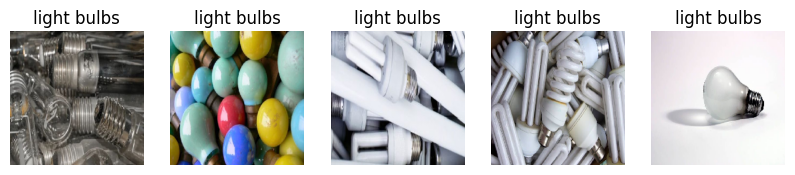

Number of test samples in class 'battery waste': 213


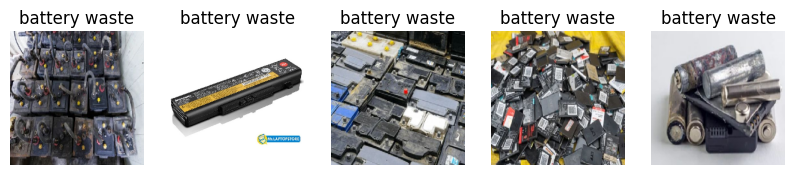

Number of test samples in class 'automobile wastes': 218


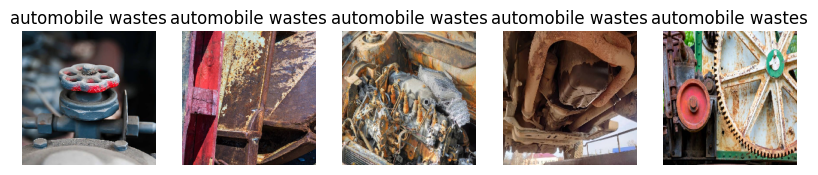

Number of test samples in class 'E-waste': 313


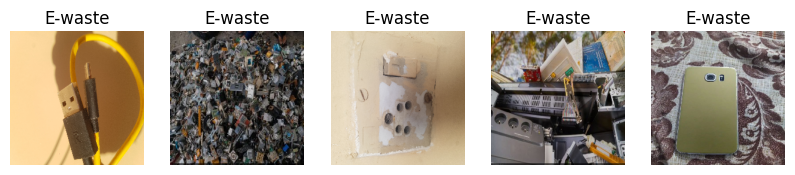

Number of test samples in class 'plastic waste': 298


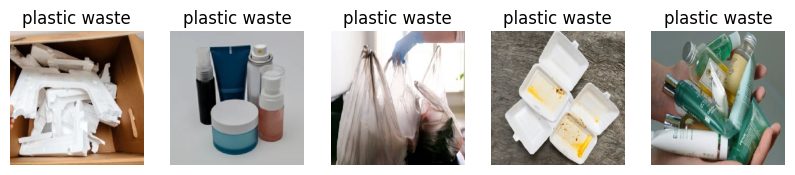

Number of test samples in class 'glass waste': 256


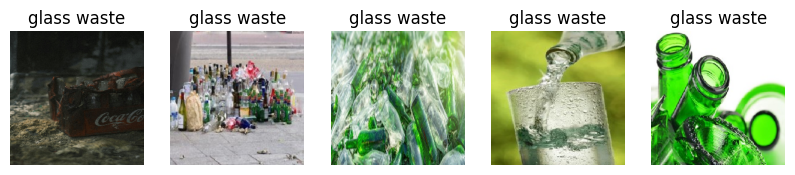

Number of test samples in class 'organic waste': 103


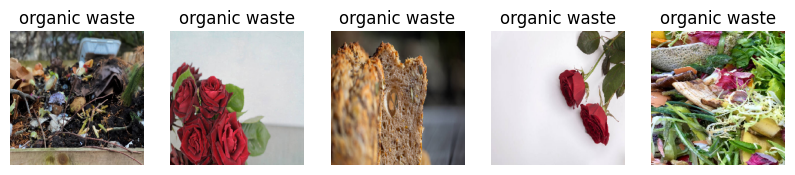

Number of test samples in class 'metal waste': 303


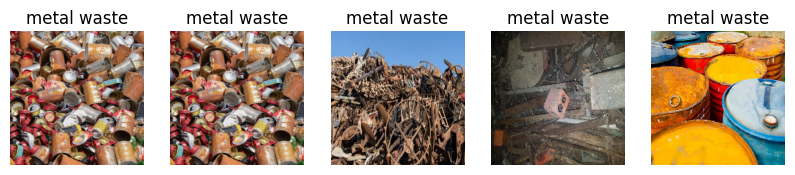

Number of test samples in class 'paper waste': 329


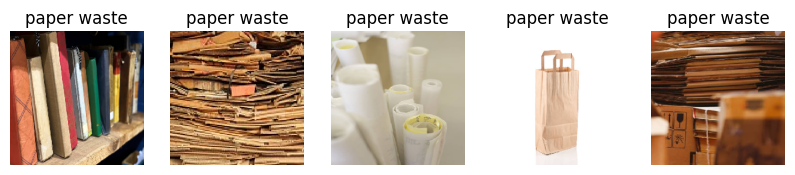

In [8]:
# Define your test directory path
test_dir = r"wastes/test"  # Replace with your actual test folder path
IMG_SIZE = (224, 224)
# List all the class names in your test dataset
class_names = os.listdir(test_dir)

# Visualize and count the number of images in each class for test data
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_images = glob.glob(os.path.join(class_dir, '*.jpg'))  # Assuming .jpg files
    print(f"Number of test samples in class '{class_name}': {len(class_images)}")

    # Visualizing some random images from each class (to get a sense of the data)
    if len(class_images) > 0:
        plt.figure(figsize=(10, 5))
        for i in range(5):  # Displaying 5 random images from this class
            plt.subplot(1, 5, i+1)
            img_path = np.random.choice(class_images)  # Randomly choose an image
            img = load_img(img_path, target_size=(IMG_SIZE))  # Load and resize image
            img_array = img_to_array(img) / 255.0  # Convert to array and normalize
            plt.imshow(img_array)
            plt.axis('off')
            plt.title(class_name)
        plt.show()




# **Data Augmentation**

Data Augmentation is a technique that helps to increase the diversity of your training data without actually collecting new data. It artificially expands the size of the training dataset by applying random transformations to the images. This helps the model generalize better and reduces overfitting.

---

## **Here are the transformations we will apply to the training data:**

### 1. **Rotation:** 
   - Random rotation of images by a certain degree.

### 2. **Shifting:** 
   - Random horizontal and vertical shifts.

### 3. **Shear:** 
   - Shear transformations that make the images slanted.

### 4. **Zoom:** 
   - Zooming into the image by a random factor.

### 5. **Flipping:** 
   - Horizontal flipping of the images.

### 6. **Rescaling:** 
   - Normalize the image pixel values to [0, 1] to make them consistent with the pretrained model inputs.

---

## **Data Augmentation for Training Set:**

The training data will undergo multiple random transformations to increase the diversity of the dataset.

### 1. **Rotation Range:** 
   - Rotate images by up to 30 degrees.

### 2. **Width and Height Shift:** 
   - Shift the images horizontally and vertically by up to 20%.

### 3. **Zoom Range:** 
   - Zoom in and out by up to 20%.

### 4. **Shear Range:** 
   - Apply shear transformations (slanting) up to 20%.

### 5. **Horizontal Flip:** 
   - Randomly flip images horizontally.

---

In [9]:
# Set parameters for image size and batch size
IMG_SIZE = (224, 224)  # Resize images to 224x224 (common for models like MobileNetV2)
BATCH_SIZE = 32  # Define batch size for training and testing
BASE_DIR = r"wastes/"  # Path to the dataset

# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize image pixel values to [0, 1]
    rotation_range=30,  # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Apply shear transformations (slanting) up to 20%
    zoom_range=0.2,  # Zoom in and out by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels during transformations
)

# Test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize image pixel values to [0, 1]

# Training data generator using the training directory
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR , 'train'),  # Path to training dataset
    target_size=IMG_SIZE,  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Batch size for training
    class_mode='categorical'  # Multi-class classification
)

# Test data generator using the test directory
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR , 'test'),  # Path to test dataset
    target_size=IMG_SIZE,  # Resize images to IMG_SIZE
    batch_size=BATCH_SIZE,  # Batch size for testing
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # Don't shuffle test data for evaluation
)


Found 9214 images belonging to 9 classes.
Found 2308 images belonging to 9 classes.


In [10]:
# Get class labels from the training dataset
class_labels = train_generator.class_indices  # returns a dictionary of class names and their indices

# Print the class labels and their corresponding encoded values
print("Class Labels and Encoded Values:")
print(class_labels)

reversed_labels = {v: k for k, v in class_labels.items()}
print("\nReversed Encoded Labels:")
print(reversed_labels)


Class Labels and Encoded Values:
{'E-waste': 0, 'automobile wastes': 1, 'battery waste': 2, 'glass waste': 3, 'light bulbs': 4, 'metal waste': 5, 'organic waste': 6, 'paper waste': 7, 'plastic waste': 8}

Reversed Encoded Labels:
{0: 'E-waste', 1: 'automobile wastes', 2: 'battery waste', 3: 'glass waste', 4: 'light bulbs', 5: 'metal waste', 6: 'organic waste', 7: 'paper waste', 8: 'plastic waste'}


In [11]:
# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path for saving model weights
filepath = './final_model_weights.keras'  # Change the extension to .keras

# Early stopping callback: monitors the validation AUC (Area Under Curve)
earlystopping = EarlyStopping(monitor='val_auc',  # Monitors validation AUC
                              mode='max',         # Stops when the validation AUC does not improve
                              patience=5,         # Patience is the number of epochs with no improvement before stopping
                              verbose=1)          # Prints messages when stopping

# Model checkpoint callback: saves the best model based on validation AUC
checkpoint = ModelCheckpoint(filepath,            # Filepath to save the best model weights
                              monitor='val_auc',  # Monitors validation AUC
                              mode='max',         # Save the model with the highest AUC
                              save_best_only=True,  # Only save the best model
                              verbose=1)          # Prints messages when saving the model

# List of callbacks to use during training
callback_list = [earlystopping, checkpoint]


# Model Development

In [12]:


# Base model: MobileNetV2 pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3),  # Adjust input size as per your requirements
                          include_top=False,          # Exclude the top classification layers
                          weights="imagenet")         # Load pre-trained weights from ImageNet


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freezing all layers in the base model
for layer in base_model.layers:
    layer.trainable = False


In [14]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2

# Load the pretrained MobileNetV2 model without the top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Redefining the model with reduced dense layer sizes
model = Sequential()

# Add the base model (MobileNetV2)
model.add(base_model)

# Add dropout and flatten layers
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Flatten())  # Flatten the output of base model to feed into fully connected layers

# Add batch normalization and dense layers with smaller sizes
model.add(BatchNormalization())  # Normalize the output of previous layer
model.add(Dense(512, activation="relu", kernel_initializer='he_uniform'))  # First dense layer
model.add(BatchNormalization())  # Another batch normalization layer
model.add(Dropout(0.2))  # Dropout layer for regularization

model.add(Dense(256, activation="relu", kernel_initializer='he_uniform'))  # Second dense layer
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))  # Third dense layer
model.add(Dropout(0.2))  # Dropout layer

# Final output layer with 9 classes and softmax activation
model.add(Dense(9, activation="softmax"))  # Softmax activation for multi-class classification


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 290s 936ms/step - accuracy: 0.3875 - loss: 2.0348 - val_accuracy: 0.7227 - val_loss: 0.8486
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 257s 876ms/step - accuracy: 0.6399 - loss: 1.1064 - val_accuracy: 0.7548 - val_loss: 0.7297
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 259s 876ms/step - accuracy: 0.6874 - loss: 0.9379 - val_accuracy: 0.7652 - val_loss: 0.7114
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 255s 868ms/step - accuracy: 0.7147 - loss: 0.8542 - val_accuracy: 0.7808 - val_loss: 0.6730
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 253s 861ms/step - accuracy: 0.7214 - loss: 0.8224 - val_accuracy: 0.7920 - val_loss: 0.6425
Epoch 6/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 256s 869ms/step - accuracy: 0.7372 - loss: 0.7603 - val_accuracy: 0.7864 - val_loss: 0.6348
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 252s 860ms/step - accuracy: 0.7444 - loss: 0.7646 - val_accuracy: 0.7951 - val_loss: 0.6094
Epoch 8/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 254s 861ms/step - accuracy: 0.7745 - loss: 0.6749 - val_accuracy: 0.8050 - val_loss: 0.5886
Epoch 9/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 255s 864ms/step - accuracy: 0.7780 - loss: 0.64

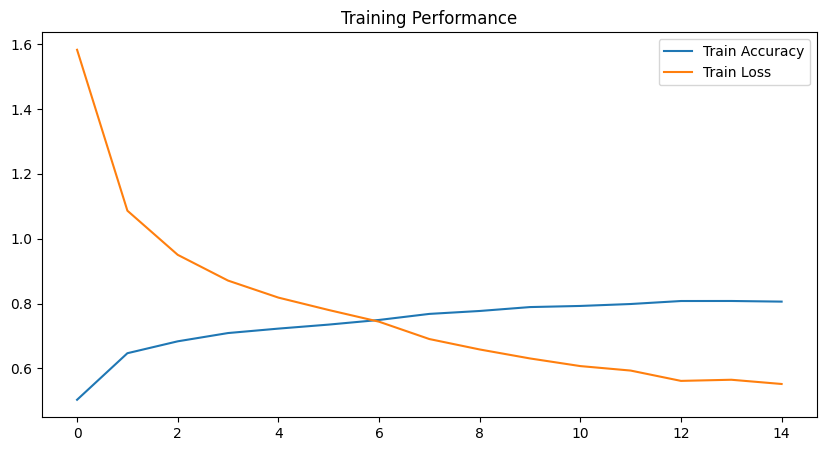

Model saved as mobilenetv2_waste_classification.h5
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 466ms/step - accuracy: 0.8288 - loss: 0.5084
Test Accuracy: 81.80%


In [15]:
# Compiling the Model
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, message="Your `PyDataset` class should call `super().__init__(**kwargs)`")

model.compile(optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a small learning rate
              loss='categorical_crossentropy',  # Using categorical crossentropy for multi-class classification
              metrics=['accuracy'])  # Metrics to track during training

# Training the Model
history = model.fit(
    train_generator,  # The training data generator
    epochs=15,  # Number of epochs
    validation_data=test_generator,  # Validation data generator
    callbacks=callback_list  # List of callbacks (early stopping and checkpoint)
)


# Saving the Final Model
model.save("mobilenetv2_waste_classification_final.h5")
print("Final Model Saved as mobilenetv2_waste_classification_final.h5")

# Evaluating the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")# Plot training performance
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title('Training Performance')
plt.show()

# Save the model
model.save("mobilenetv2_waste_classification.h5")
print("Model saved as mobilenetv2_waste_classification.h5")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [16]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 490ms/step

Classification Report:
                    precision    recall  f1-score   support

          E-waste       0.78      0.85      0.81       313
automobile wastes       0.77      0.88      0.82       218
    battery waste       0.87      0.75      0.81       213
      glass waste       0.80      0.82      0.81       256
      light bulbs       0.83      0.79      0.81       105
      metal waste       0.75      0.78      0.77       308
    organic waste       0.85      0.92      0.89       223
      paper waste       0.88      0.86      0.87       343
    plastic waste       0.86      0.72      0.78       329

         accuracy                           0.82      2308
        macro avg       0.82      0.82      0.82      2308
     weighted avg       0.82      0.82      0.82      2308



73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step


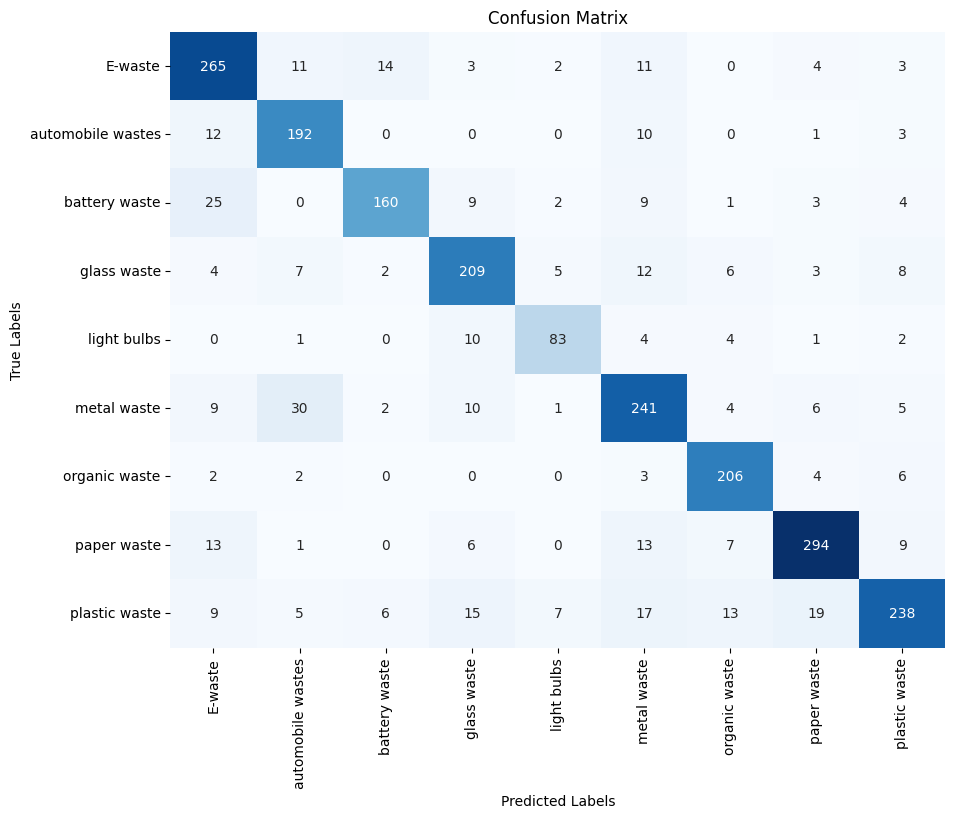

In [17]:
# Import additional necessary libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
test_predictions = model.predict(test_generator, verbose=1)

# Convert predictions to label indices
predicted_labels = np.argmax(test_predictions, axis=1)

# Get the true labels from the test_generator
true_labels = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



# Model prediction

In [18]:
!ls wastes/test/E-waste/

'e-waste (100).jpg'  'e-waste (197).jpg'  'e-waste (292).jpg'
'e-waste (101).jpg'  'e-waste (198).jpg'  'e-waste (293).jpg'
'e-waste (102).jpg'  'e-waste (199).jpg'  'e-waste (294).jpg'
'e-waste (103).jpg'  'e-waste (19).jpg'   'e-waste (295).jpg'
'e-waste (104).jpg'  'e-waste (1).jpg'	  'e-waste (296).jpg'
'e-waste (105).jpg'  'e-waste (200).jpg'  'e-waste (297).jpg'
'e-waste (106).jpg'  'e-waste (201).jpg'  'e-waste (298).jpg'
'e-waste (107).jpg'  'e-waste (202).jpg'  'e-waste (299).jpg'
'e-waste (108).jpg'  'e-waste (203).jpg'  'e-waste (29).jpg'
'e-waste (109).jpg'  'e-waste (204).jpg'  'e-waste (2).jpg'
'e-waste (10).jpg'   'e-waste (205).jpg'  'e-waste (300).jpg'
'e-waste (110).jpg'  'e-waste (206).jpg'  'e-waste (301).jpg'
'e-waste (111).jpg'  'e-waste (207).jpg'  'e-waste (302).jpg'
'e-waste (112).jpg'  'e-waste (208).jpg'  'e-waste (303).jpg'
'e-waste (113).jpg'  'e-waste (209).jpg'  'e-waste (304).jpg'
'e-waste (114).jpg'  'e-waste (20).jpg'   'e-waste (305).jpg'
'e-waste (11

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: E-waste


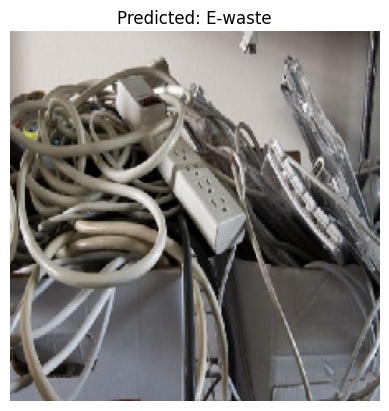

In [19]:


# Load the trained model
model = load_model('mobilenetv2_waste_classification.h5')

# Set image size and path
IMG_SIZE = (224, 224)  # Same as the model input size
img_path = r"wastes/test/E-waste/e-waste (216).jpg"  # Replace with the path to the image you want to predict

# Preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)  # Load and resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the highest predicted class

# Manually define the class labels (use the folder names in your dataset)
# Replace this path with the actual path to your 'train' directory
train_dir = r"wastes/train"
class_labels = sorted(os.listdir(train_dir))  # Sort to ensure consistent order

# Get the predicted class label
predicted_class = class_labels[predicted_class_index]

# Output the prediction
print(f"Predicted class: {predicted_class}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [20]:
!ls "wastes/test/organic waste/organic waste (5).jpeg"

'wastes/test/organic waste/organic waste (5).jpeg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: organic waste


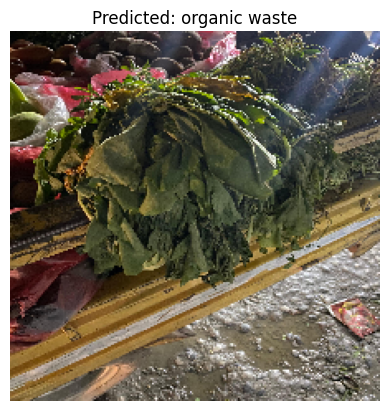

In [21]:
import os

# Load the trained model
model = load_model('mobilenetv2_waste_classification.h5')

# Set image size and path
IMG_SIZE = (224, 224)  # Same as the model input size
img_path = r"wastes/test/organic waste/organic waste (5).jpeg"  # Replace with the path to the image you want to predict

# Preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)  # Load and resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the highest predicted class

# Manually define the class labels (use the folder names in your dataset)
# Replace this path with the actual path to your 'train' directory
train_dir = r"wastes/train"
class_labels = sorted(os.listdir(train_dir))  # Sort to ensure consistent order

# Get the predicted class label
predicted_class = class_labels[predicted_class_index]

# Output the prediction
print(f"Predicted class: {predicted_class}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [22]:
!ls "wastes/test/automobile wastes/automobile waste  (20).jpg"

'wastes/test/automobile wastes/automobile waste  (20).jpg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: E-waste


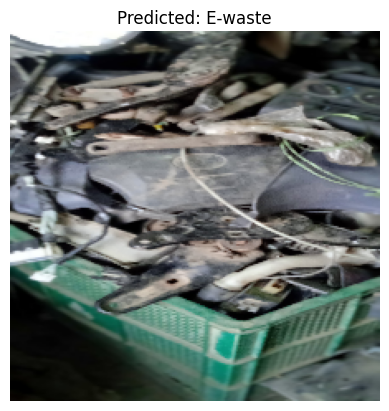

In [23]:


# Load the trained model
model = load_model('mobilenetv2_waste_classification.h5')

# Set image size and path
IMG_SIZE = (224, 224)  # Same as the model input size
img_path = r"wastes/test/automobile wastes/automobile waste  (20).jpg"  # Replace with the path to the image you want to predict

# Preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)  # Load and resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the highest predicted class

# Manually define the class labels (use the folder names in your dataset)
# Replace this path with the actual path to your 'train' directory
train_dir = r"wastes/train"
class_labels = sorted(os.listdir(train_dir))  # Sort to ensure consistent order

# Get the predicted class label
predicted_class = class_labels[predicted_class_index]

# Output the prediction
print(f"Predicted class: {predicted_class}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [24]:
!ls "wastes/test/paper waste/"

'paper waste (100).jpg'  'paper waste (1).png'	  'paper waste (305).jpg'
'paper waste (101).jpg'  'paper waste (200).jpg'  'paper waste (306).jpg'
'paper waste (102).jpg'  'paper waste (201).jpg'  'paper waste (307).jpg'
'paper waste (103).jpg'  'paper waste (202).jpg'  'paper waste (308).jpg'
'paper waste (104).jpg'  'paper waste (203).jpg'  'paper waste (309).jpg'
'paper waste (105).jpg'  'paper waste (204).jpg'  'paper waste (310).jpg'
'paper waste (106).jpg'  'paper waste (205).jpg'  'paper waste (311).jpg'
'paper waste (107).jpg'  'paper waste (206).jpg'  'paper waste (312).jpg'
'paper waste (108).jpg'  'paper waste (207).jpg'  'paper waste (313).jpg'
'paper waste (109).jpg'  'paper waste (208).jpg'  'paper waste (314).jpg'
'paper waste (10).jpg'	 'paper waste (209).jpg'  'paper waste (315).jpg'
'paper waste (10).png'	 'paper waste (20).jpg'   'paper waste (316).jpg'
'paper waste (110).jpg'  'paper waste (210).jpg'  'paper waste (317).jpg'
'paper waste (111).jpg'  'paper waste (21

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: paper waste


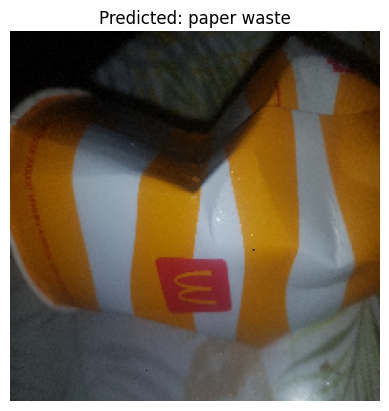

In [25]:
# Load the trained model
model = load_model('mobilenetv2_waste_classification.h5')

# Set image size and path
IMG_SIZE = (224, 224)  # Same as the model input size
img_path = r"wastes/test/paper waste/paper waste (28).jpg"  # Replace with the path to the image you want to predict

# Preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)  # Load and resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the highest predicted class

# Manually define the class labels (use the folder names in your dataset)
# Replace this path with the actual path to your 'train' directory
train_dir = r"wastes/train"
class_labels = sorted(os.listdir(train_dir))  # Sort to ensure consistent order

# Get the predicted class label
predicted_class = class_labels[predicted_class_index]

# Output the prediction
print(f"Predicted class: {predicted_class}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()
